In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy.io
from PIL import Image


In [3]:
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        # 🔹 VGG-16 Tabanlı Özellik Çıkarıcı (Frontend)
        self.frontend = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
        )

        # 🔹 Boşluklu Evrişim Katmanı (Backend)
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, dilation=2, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, 1),
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x, torch.sum(x)  # Yoğunluk haritası ve tahmini kişi sayısı


In [22]:
import scipy.io

density_path = "/content/drive/MyDrive/dataset/train_data/ground_truth/GT_IMG_14.mat"
density_data = scipy.io.loadmat(density_path)

print(density_data)  # İçeriği ekrana yazdır


{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Oct 23 13:18:32 2015', '__version__': '1.0', '__globals__': [], 'image_info': array([[array([[(array([[ 999.56760734,    7.36341688],
                       [ 960.04480032,   21.7353467 ],
                       [ 994.77696407,   64.85113618],
                       [1009.14889389,   86.40903091],
                       [ 934.89392313,   31.31663325],
                       [ 937.28924477,   60.0604929 ],
                       [ 966.03310442,   76.82774436],
                       [ 952.85883541,   51.67686717],
                       [1013.93953717,  118.74587302],
                       [1017.53251962,  160.66400167],
                       [ 987.59099915,  166.65230577],
                       [ 974.41673015,  127.12949875],
                       [ 885.78982956,   10.95639933],
                       [ 848.66234418,    1.37511278],
                       [ 888.1851512 ,   55.26984963],
                       

In [15]:
import numpy as np
import scipy.io
import scipy.spatial
from PIL import Image
import cv2

def generate_density_map(image_path, mat_path):
    # 🔹 Görselin boyutunu al
    image = Image.open(image_path)
    width, height = image.size

    # 🔹 .mat dosyasını yükle
    mat = scipy.io.loadmat(mat_path)
    points = mat['image_info'][0, 0]['location'][0, 0]  # İnsan koordinatları

    # 🔹 Boş bir yoğunluk haritası oluştur
    density_map = np.zeros((height, width), dtype=np.float32)

    # 🔹 Gaussian kernel ile her noktayı yoğunluk haritasına ekleyelim
    for point in points:
        x, y = int(point[0]), int(point[1])  # Koordinatları tam sayıya çevir
        if 0 <= x < width and 0 <= y < height:
            density_map[y, x] += 1  # Belirtilen noktaya yoğunluk ekle

    # 🔹 Gaussian Blur uygula (yoğunluğu dağıt)
    density_map = cv2.GaussianBlur(density_map, (15, 15), 0)

    return density_map

# Kullanım
image_path = "/content/drive/MyDrive/dataset/train_data/images/IMG_18.jpg"
mat_path = "/content/drive/MyDrive/dataset/train_data/ground_truth/GT_IMG_18.mat"
density_map = generate_density_map(image_path, mat_path)

# 🔹 Density Map'i kaydet
np.save("/content/drive/MyDrive/dataset/train_data/density_maps/GT_IMG_18.npy", density_map)


In [6]:
print(predicted_density.shape, ground_truth_density.shape)


torch.Size([3, 1, 99, 128]) torch.Size([3, 1, 793, 1024])


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torch.nn.functional as F

# 🔹 Görselleri ve yoğunluk haritalarını aynı boyuta getiren fonksiyon
def pad_image(image, target_size):
    """Görselleri en büyük boyuta göre pad eder"""
    c, h, w = image.shape
    target_h, target_w = target_size

    padded_image = torch.zeros((c, target_h, target_w))  # Siyah arka planlı yeni tensör oluştur
    padded_image[:, :h, :w] = image  # Orijinal görüntüyü üst sol köşeye yerleştir
    return padded_image

def pad_density_map(density_map, target_size):
    """Density map'leri en büyük boyuta göre pad eder"""
    _, h, w = density_map.shape
    target_h, target_w = target_size

    padded_density = torch.zeros((1, target_h, target_w))
    padded_density[:, :h, :w] = density_map
    return padded_density

# 🔹 Veri kümesi sınıfı
class CrowdDataset(Dataset):
    def __init__(self, image_paths, density_paths, transform=None):
        self.image_paths = image_paths
        self.density_paths = density_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 🔹 Görüntüyü yükle ve dönüşümleri uygula
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # 🔹 Density Map (.npy) yükleme
        density_map = np.load(self.density_paths[idx])
        density_map = torch.tensor(density_map, dtype=torch.float32).unsqueeze(0)  # (1, H, W) olacak şekilde

        # 🔹 Kişi sayısını yoğunluk haritası toplamından al
        ground_truth_count = torch.tensor([density_map.sum()], dtype=torch.float32)

        return image, density_map, ground_truth_count


# 🔹 Özel collate fonksiyonu (Görselleri ve yoğunluk haritalarını pad eder)
def collate_fn(batch):
    images, density_maps, counts = zip(*batch)

    # 🔹 En büyük boyutları bul
    max_h = max(img.shape[1] for img in images)
    max_w = max(img.shape[2] for img in images)
    target_size = (max_h, max_w)

    # 🔹 Görselleri ve yoğunluk haritalarını pad et
    padded_images = [pad_image(img, target_size) for img in images]
    padded_density_maps = [pad_density_map(dm, target_size) for dm in density_maps]

    return torch.stack(padded_images), torch.stack(padded_density_maps), torch.stack(counts)


# 🔹 Transform işlemleri
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 🔹 Veri seti yolları
image_paths = [
    "/content/drive/MyDrive/dataset/train_data/images/IMG_14.jpg",
    "/content/drive/MyDrive/dataset/train_data/images/IMG_15.jpg",
    "/content/drive/MyDrive/dataset/train_data/images/IMG_18.jpg"
]

density_paths = [
    "/content/drive/MyDrive/dataset/train_data/density_maps/GT_IMG_14.npy",
    "/content/drive/MyDrive/dataset/train_data/density_maps/GT_IMG_15.npy",
    "/content/drive/MyDrive/dataset/train_data/density_maps/GT_IMG_18.npy"
]

# 🔹 Dataset ve DataLoader
train_dataset = CrowdDataset(image_paths, density_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)  # collate_fn eklendi

# 🔹 Model ve optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CSRNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 🔹 Eğitim döngüsü
# 🔹 Eğitim döngüsü
# 🔹 Eğitim döngüsü
num_epochs = 10
for epoch in range(num_epochs):
    for images, ground_truth_density, ground_truth_count in train_loader:
        images, ground_truth_density = images.to(device), ground_truth_density.to(device)

        # 🔹 Eğer ground_truth_count tuple ise, tensor olarak birleştir
        if isinstance(ground_truth_count, tuple):
            ground_truth_count = torch.stack(list(ground_truth_count))

        ground_truth_count = ground_truth_count.to(device)

        optimizer.zero_grad()
        predicted_density, predicted_count = model(images)
        # 🔹 Tahmini kişi sayısını yoğunluk haritasından al
        predicted_count = predicted_density.sum(dim=[1, 2, 3])

        # 🔹 Loss hesapla
        ground_truth_density = F.interpolate(ground_truth_density, size=predicted_density.shape[2:], mode="bilinear", align_corners=False)
        total_loss = nn.MSELoss()(predicted_density, ground_truth_density) + 0.01 * nn.L1Loss()(predicted_count, ground_truth_count)


        total_loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss.item():.4f}")



# 🔹 Eğitilmiş modeli kaydet
torch.save(model.state_dict(), "csrnet_weights.pth")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 4.5068
Epoch 2/10, Loss: 4.4041
Epoch 3/10, Loss: 4.3017
Epoch 4/10, Loss: 4.1984
Epoch 5/10, Loss: 4.0964
Epoch 6/10, Loss: 3.9943
Epoch 7/10, Loss: 3.8900
Epoch 8/10, Loss: 3.7890
Epoch 9/10, Loss: 3.6909
Epoch 10/10, Loss: 3.5939


In [24]:
# Test verisi yolları
test_image_paths = ["/content/drive/MyDrive/dataset/test_data/images/IMG_29.jpg", "/content/drive/MyDrive/dataset/test_data/images/IMG_30.jpg"]
test_density_paths = ["/content/drive/MyDrive/dataset/test_data/density_maps/GT_IMG_29.npy", "/content/drive/MyDrive/dataset/test_data/density_maps/GT_IMG_30.npy"]

# Test veri seti
test_dataset = CrowdDataset(test_image_paths, test_density_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Modelin test edilmesi
model.eval()  # Test aşamasına geçtiğimizi belirtiyoruz
for images, ground_truth_density, ground_truth_count in test_loader:
    images = images.to(device)
    ground_truth_density = ground_truth_density.to(device)
    ground_truth_count = ground_truth_count.to(device)

    with torch.no_grad():  # Gradyanları hesaba katmıyoruz
        predicted_density, predicted_count = model(images)

    # Test sonuçlarını değerlendirme (örneğin, görsel olarak veya sayısal)
    print(f"Predicted Count: {predicted_count.item()}, Ground Truth Count: {ground_truth_count.item()}")
    # Burada, tahmin edilen yoğunluk haritasını ve sayıyı görselleştirebilirsiniz.



Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 271, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


Predicted Count: 536.120849609375, Ground Truth Count: 309.1537780761719
Predicted Count: 295.7425537109375, Ground Truth Count: 307.0526123046875


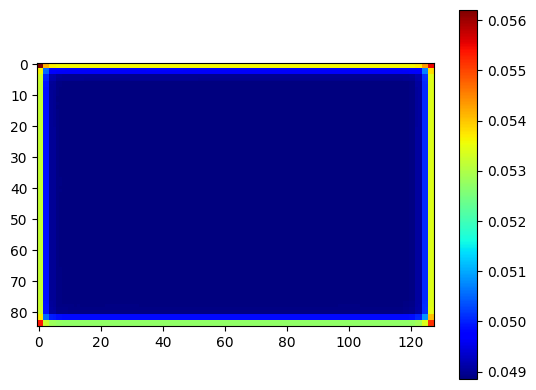

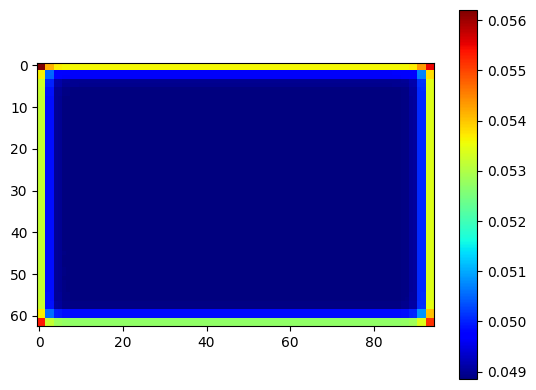

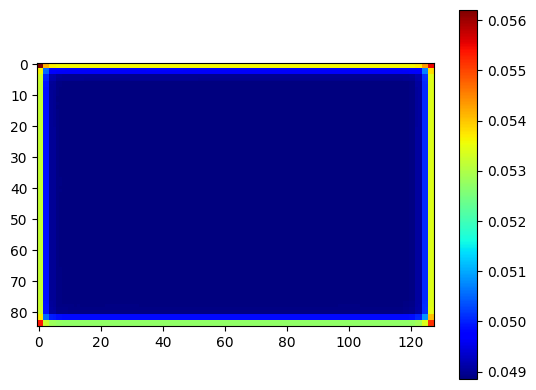

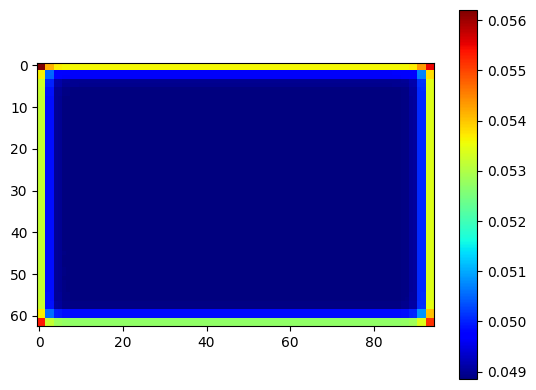

In [27]:
import matplotlib.pyplot as plt
import torch
from PIL import Image

# Test verisini yükleyin
test_image_path = "/content/drive/MyDrive/dataset/test_data/images/IMG_29.jpg"  # Test görselinin yolu
image = Image.open(test_image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Modeli test modunda çalıştırın
model.eval()  # Eğitim modundan test moduna geçiş
with torch.no_grad():  # Geri yayılım yapma
    predicted_density, _ = model(image_tensor)

# Tahmin edilen yoğunluk haritasını görselleştirin
predicted_density = predicted_density.squeeze().cpu().numpy()  # Tensor'u numpy array'e çevirin
plt.imshow(predicted_density, cmap='jet')  # Jet renk haritası ile görselleştirme
plt.colorbar()  # Renk çubuğu ekleyin
plt.show()

test_image_path = "/content/drive/MyDrive/dataset/test_data/images/IMG_30.jpg"  # Test görselinin yolu
image = Image.open(test_image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

# Modeli test modunda çalıştırın
model.eval()  # Eğitim modundan test moduna geçiş
with torch.no_grad():  # Geri yayılım yapma
    predicted_density, _ = model(image_tensor)

# Tahmin edilen yoğunluk haritasını görselleştirin
predicted_density = predicted_density.squeeze().cpu().numpy()  # Tensor'u numpy array'e çevirin
plt.imshow(predicted_density, cmap='jet')  # Jet renk haritası ile görselleştirme
plt.colorbar()  # Renk çubuğu ekleyin
plt.show()

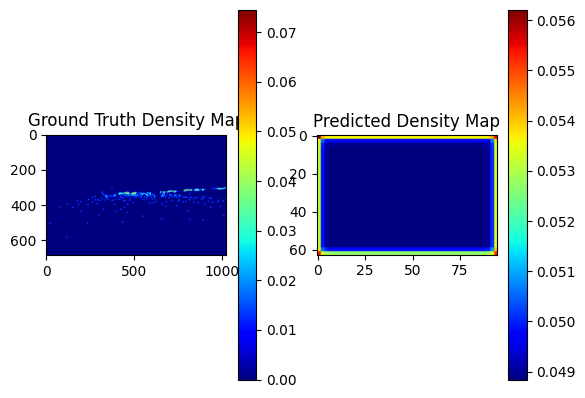

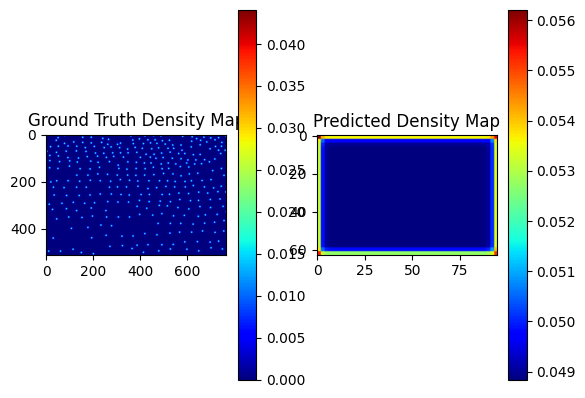

In [30]:
ground_truth_density_path = "/content/drive/MyDrive/dataset/test_data/density_maps/GT_IMG_29.npy"  # Gerçek yoğunluk haritası
ground_truth_density = np.load(ground_truth_density_path)

plt.subplot(1, 2, 1)
plt.imshow(ground_truth_density, cmap='jet')
plt.title("Ground Truth Density Map")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(predicted_density, cmap='jet')
plt.title("Predicted Density Map")
plt.colorbar()

plt.show()

ground_truth_density_path = "/content/drive/MyDrive/dataset/test_data/density_maps/GT_IMG_30.npy"  # Gerçek yoğunluk haritası
ground_truth_density = np.load(ground_truth_density_path)

plt.subplot(1, 2, 1)
plt.imshow(ground_truth_density, cmap='jet')
plt.title("Ground Truth Density Map")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(predicted_density, cmap='jet')
plt.title("Predicted Density Map")
plt.colorbar()

plt.show()